# 期待値伝搬法を用いたガウス過程による二値分類

## ガウス過程の実装

In [1]:
import numpy as np
from scipy.stats import norm

class GaussianProcessClassifierEP:
    def __init__(self, kernel, beta, epochs, verbose):
        self.kernel = kernel
        self.beta = beta
        self.epochs = epochs
        self.verbose = verbose

        self.x_fit = None
        self.mu_f_posterior = None
        self.sigma_f_posterior = None

    def fit(self, x_fit, y_fit):
        mu_f_posterior, sigma_f_posterior = self._fit_f(x_fit, y_fit, self.kernel, self.beta)
        self.x_fit = x_fit
        self.mu_f_posterior = mu_f_posterior
        self.sigma_f_posterior = sigma_f_posterior

        return self

    def predict(self, x_predict):
        y_predict = self.predict_proba(x_predict)
        y_predict = np.argmax(y_predict, axis = 1)

        return y_predict

    def predict_proba(self, x_predict):
        _, _, y_predict = self.predict_dist(x_predict)

        return y_predict

    def predict_dist(self, x_predict):
        mu_f_predict, sigma_f_predict = self._predict_f(x_predict, self.x_fit, self.mu_f_posterior, self.sigma_f_posterior, self.kernel, self.beta)
        y_predict = self._predict_y(mu_f_predict, sigma_f_predict)

        return mu_f_predict, sigma_f_predict, y_predict

    def _fit_f(self, x_fit, y_fit, kernel, beta):
        # 期待値伝搬法を用いて潜在関数の事後分布を求める。
        # x_fit: (n_fit, d)
        # y_fit: (n_fit,)

        # データを、データ同士の内積に変換する。
        # (n_fit, n_fit) = (n_fit, d) * (d, n_fit) + (n_fit, n_fit)
        k_fit_fit_beta = self._calc_inner_product(x_fit, x_fit, kernel) + np.eye(x_fit.shape[0]) / beta
        # (n_fit, n_fit)
        k_fit_fit_beta_inv = np.linalg.inv(k_fit_fit_beta)

        # 近似因子のパラメータを初期化する。
        # (n_fit, n_fit)
        sigma_f_likelihood_inv = np.diag(np.random.normal(size = x_fit.shape[0]))
        # (n_fit, n_fit)
        sigma_f_likelihood = np.linalg.inv(sigma_f_likelihood_inv)
        # (n_fit,)
        mu_f_likelihood = np.random.normal(size = x_fit.shape[0])

        # 現在の近似因子のパラメータを用いて、潜在関数の事後分布の近似分布 (7.40) を求める。
        # (7.41): (n_fit, n_fit) = (n_fit, n_fit) + (n_fit, n_fit)
        sigma_f_posterior_inv = k_fit_fit_beta_inv + sigma_f_likelihood_inv
        # (7.41): (n_fit, n_fit)
        sigma_f_posterior = np.linalg.inv(sigma_f_posterior_inv)
        # (7.42): (n_fit,) = (n_fit, n_fit) * (n_fit, n_fit) * (n_fit,)
        mu_f_posterior = np.dot(np.dot(sigma_f_posterior, sigma_f_likelihood_inv), mu_f_likelihood)

        # 収束確認用に更新前の近似分布を保存しておく場所。
        # (n_fit, n_fit)
        sigma_f_posterior_prev = np.zeros((sigma_f_posterior.shape[0], sigma_f_posterior.shape[1]))
        # (n_fit,)
        mu_f_posterior_prev = np.zeros(mu_f_posterior.shape[0])
    
        for epoch in range(self.epochs):
            for i in range(x_fit.shape[0]):
                # 更新が収束したか確認するために、更新前との距離を求め、出力する。
                if self.verbose:
                    dist_mu = (np.sum(mu_f_posterior - mu_f_posterior_prev) ** 2) ** 0.5
                    dist_sigma = (np.sum(sigma_f_posterior - sigma_f_posterior_prev) ** 2) ** 0.5
                    print("epoch = {:2d}, i = {:2d}, mu = {:10.4f}, sigma = {:10.4f}".format(epoch, i, dist_mu, dist_sigma))

                # 更新する近似因子を除いた、潜在関数の事後分布の近似分布 (7.44) を求める。
                # (7.45): (1,) = (1,) - (1,)
                sigma_f_posterior_except_i_inv = sigma_f_posterior_inv[i, i] - sigma_f_likelihood_inv[i, i]
                # (7.45): (1,)
                sigma_f_posterior_except_i = 1 / sigma_f_posterior_except_i_inv
                # (7.46): (1,) = (1,) * ((1,) * (1,) - (1,) * (1,))
                mu_f_posterior_except_i = sigma_f_posterior_except_i * (sigma_f_posterior_inv[i, i] * mu_f_posterior[i] - sigma_f_likelihood_inv[i, i] * mu_f_likelihood[i])

                # 更新する近似因子を真の因子に差し替えた、潜在関数の事後分布の近似分布 (7.47) を求める。
                # (7.50) / y_fit[i]: (1,) = (1,) / ((1,) + (1,))
                a_i = mu_f_posterior_except_i / ((1 + sigma_f_posterior_except_i) ** 0.5)
                # (1,) = (1,) / ((1,) + (1,))
                b_i = sigma_f_posterior_except_i / ((1 + sigma_f_posterior_except_i) ** 0.5)
                # (1,) = ((1,) * (1,)) / ((1,) * (1,))
                pdf_over_cdf = norm.pdf(y_fit[i] * a_i) / norm.cdf(y_fit[i] * a_i)
                # (7.49): (1,) - (1,) * (1,) * ((1,) * (1,) + (1,))
                sigma_f_posterior_i_new = sigma_f_posterior_except_i - (b_i ** 2) * pdf_over_cdf * (y_fit[i] * a_i + pdf_over_cdf)
                # (1,)
                sigma_f_posterior_i_new_inv = 1 / sigma_f_posterior_i_new
                # (7.48): (1,) + (1,) * (1,) * (1,)
                mu_f_posterior_i_new = mu_f_posterior_except_i + y_fit[i] * b_i * pdf_over_cdf

                # 近似因子のパラメータを更新する。
                # (7.51): (1,) = (1,) - (1,)
                sigma_f_likelihood_inv[i, i] = sigma_f_posterior_i_new_inv - sigma_f_posterior_except_i_inv
                # (n_fit, n_fit)
                # ★本では逆行列を求めているが、特異行列になってしまうことがあるため、ここでは代わりに擬似逆行列を求めている。
                sigma_f_likelihood = np.linalg.pinv(sigma_f_likelihood_inv)
                # (7.52): (1,) = (1,) * ((1,) * (1,) - (1,) * (1,))
                mu_f_likelihood[i] = sigma_f_likelihood[i, i] * (mu_f_posterior_i_new * sigma_f_posterior_i_new_inv - mu_f_posterior_except_i * sigma_f_posterior_except_i_inv)

                # 現在の近似因子のパラメータを用いて、潜在関数の事後分布の近似分布 (7.40) を求める。
                # (n_fit, n_fit)
                sigma_f_posterior_prev = sigma_f_posterior
                # (7.41): (n_fit, n_fit) = (n_fit, n_fit) + (n_fit, n_fit)
                sigma_f_posterior_inv = k_fit_fit_beta_inv + sigma_f_likelihood_inv
                # (7.41): (n_fit, n_fit)
                sigma_f_posterior = np.linalg.inv(sigma_f_posterior_inv)
                # (n_fit,)
                mu_f_posterior_prev = mu_f_posterior
                # (7.42): (n_fit,) = (n_fit, n_fit) * (n_fit, n_fit) * (n_fit,)
                mu_f_posterior = np.dot(np.dot(sigma_f_posterior, sigma_f_likelihood_inv), mu_f_likelihood)

        # (n_fit,), (n_fit, n_fit)
        return mu_f_posterior, sigma_f_posterior

    def _predict_f(self, x_predict, x_fit, mu_f_posterior, sigma_f_posterior, kernel, beta):
        # 潜在関数の予測分布を求める。
        # (7.21) の近似である (7.31) を計算する。
        # x_predict: (n_predict, d)
        # x_fit: (n_fit, d)
        # mu_f_posterior: (n_fit,)
        # sigma_f_posterior: (n_fit, n_fit)

        # データを、データ同士の内積に変換する。
        # (n_fit, n_fit) = (n_fit, d) * (d, n_fit) + (n_fit, n_fit)
        k_fit_fit_beta = self._calc_inner_product(x_fit, x_fit, kernel) + np.eye(x_fit.shape[0]) / beta
        # (n_fit, n_fit)
        k_fit_fit_beta_inv = np.linalg.inv(k_fit_fit_beta)
        # (n_fit, n_predict) = (n_fit, d) * (d, n_predict)
        k_fit_predict = self._calc_inner_product(x_fit, x_predict, kernel)
        # (n_predict, n_predict) = (n_predict, d) * (d, n_predict) + (n_predict, n_predict)
        k_predict_predict_beta = self._calc_inner_product(x_predict, x_predict, kernel) + np.eye(x_predict.shape[0]) / beta

        # 潜在関数の予測分布の近似分布を求める。
        # (7.32): (n_predict,) = (n_predict, n_fit) * (n_fit, n_fit) * (n_fit,)
        mu_f_predict = np.dot(np.dot(k_fit_predict.T, k_fit_fit_beta_inv), mu_f_posterior)
        # (7.33): (n_predict, n_predict) = (n_predict, n_predict) - (n_predict, n_fit) * ((n_fit, n_fit) - (n_fit, n_fit)) * (n_fit, n_predict)
        # ★本では k_fit_fit_beta + sigma_f_posterior_inv だが、共分散行列と精度行列の和をとるのはおかしくない……？
        #   ここでは、sigma_f_posterior_inv の代わりに sigma_f_posterior を足している。
        #   ただし、k_fit_fit_beta の影響が支配的なようで、sigma_f_posterior_inv でも sigma_f_posterior でも結果はほぼ変わらない。
        sigma_f_predict = k_predict_predict_beta - np.dot(np.dot(k_fit_predict.T, np.linalg.inv(k_fit_fit_beta + sigma_f_posterior)), k_fit_predict)

        # (n_predict,), (n_predict, n_predict)
        return mu_f_predict, sigma_f_predict

    def _predict_y(self, mu_f_predict, sigma_f_predict):
        # 目的変数の予測分布を求める。
        # (7.22) の近似である (7.34) を計算する。
        # mu_f_predict: (n_predict,)
        # sigma_f_predict: (n_predict, n_predict)

        # (n_predict, 2)
        y_predict = np.zeros((mu_f_predict.shape[0], 2))
        # (7.35): (n_predict,) = (n_predict,) * (n_predict,) / ((n_predict,) + (n_predict,))
        y_predict[:, 0] = norm.cdf(-1 * mu_f_predict / np.sqrt(1 + np.diag(sigma_f_predict)))
        # (7.35): (n_predict,) = (n_predict,) * (n_predict,) / ((n_predict,) + (n_predict,))
        y_predict[:, 1] = norm.cdf(+1 * mu_f_predict / np.sqrt(1 + np.diag(sigma_f_predict)))

        # (n_predict, 2)
        return y_predict

    def _calc_inner_product(self, xs_left, xs_right, kernel):
        # カーネル関数を用いて行列同士の内積を計算する。
        # xs_left: (n_left, d)
        # xs_right: (n_right, d)

        # (n_left, n_right)
        k = np.zeros((xs_left.shape[0], xs_right.shape[0]))
        for i_left in range(xs_left.shape[0]):
            for i_right in range(xs_right.shape[0]):
                k[i_left, i_right] = kernel(xs_left[i_left, :], xs_right[i_right, :])

        # (n_left, n_right)
        return k

## 実行例

### セットアップ

In [2]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### サンプルデータの生成

学習データを生成する。  
クラスターを10個生成し、そのうちの5個を正例、残りの5個を負例にする。  
各クラスターで10点ずつ、計100点のデータを作る。

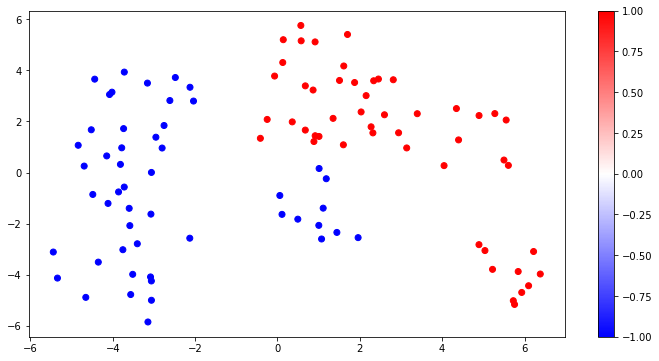

In [3]:
np.random.seed(seed = 2021)
x_seed = np.random.rand(10, 2) * 10 - 5

x_fit = np.tile(x_seed, (10, 1)) + np.random.rand(100, 2) * 3 - 1.5
y_fit = np.array([1 if i % 2 == 0 else -1 for i in range(x_fit.shape[0])])

plt.figure(figsize = (12, 6))
plt.scatter(x = x_fit[:, 0], y = x_fit[:, 1], c = y_fit, cmap = "bwr")
plt.colorbar()
plt.show()

### 学習

学習データを用いて、ガウス過程を学習させる。  
カーネル関数には、RBFカーネルを用いる。

In [4]:
sigma = 1
l = 1
rbf = lambda x_left, x_right: sigma * np.exp(-1 * np.sum((x_left - x_right) ** 2) / (2 * l ** 2))

gp = GaussianProcessClassifierEP(kernel = rbf, beta = 1, epochs = 5, verbose = True)
gp = gp.fit(x_fit, y_fit)

epoch =  0, i =  0, mu =    96.6739, sigma =   163.5488
epoch =  0, i =  1, mu =     3.2254, sigma =    59.1263
epoch =  0, i =  2, mu =    62.0793, sigma =   118.9138
epoch =  0, i =  3, mu =    12.6994, sigma =    38.9906
epoch =  0, i =  4, mu =   226.2192, sigma =   805.1513
epoch =  0, i =  5, mu =    13.5091, sigma =    66.1738
epoch =  0, i =  6, mu =    99.7287, sigma =   229.1978
epoch =  0, i =  7, mu =     0.3337, sigma =     0.0049
epoch =  0, i =  8, mu =     0.9779, sigma =     1.7044
epoch =  0, i =  9, mu =     0.3354, sigma =     0.1222
epoch =  0, i = 10, mu =     2.8350, sigma =     9.2128
epoch =  0, i = 11, mu =    18.4621, sigma =    74.1622
epoch =  0, i = 12, mu =     1.0526, sigma =    21.7816
epoch =  0, i = 13, mu =    15.7803, sigma =    94.1474
epoch =  0, i = 14, mu =   178.9650, sigma =   707.6430
epoch =  0, i = 15, mu =     0.5993, sigma =     0.0548
epoch =  0, i = 16, mu =     0.2784, sigma =     0.0048
epoch =  0, i = 17, mu =     5.2940, sigma =    

### 予測

テストデータの各点が正例である確率を予測する。

In [5]:
x_predict = np.array([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)])
mu_f_predict, sigma_f_predict, p_predict = gp.predict_dist(x_predict)

予測結果を図示する。図の意味は以下の通り。

* 形：データ点の真のクラス。○が正例、×が負例を表す。
* 色：予測して得た、データ点が正例である確率。赤に近いほど正例、青に近いほど負例であることを表す。
* 大きさ：潜在関数の標準偏差。大きいほど、予測に自信がないことを表す。

In [6]:
def plot(x_fit, y_fit, x_predict, p_predict, sigma_f_predict):
    s = np.sqrt(np.diag(sigma_f_predict))
    s = ((s - s.min()) / s.std() + 0.1) * 50
    plt.figure(figsize = (12, 6))
    plt.scatter(x = x_fit[y_fit > 0, 0], y = x_fit[y_fit > 0, 1], c = "black", marker = "o", label = "Training (Positive)")
    plt.scatter(x = x_fit[y_fit < 0, 0], y = x_fit[y_fit < 0, 1], c = "black", marker = "x", label = "Training (Negative)")
    plt.scatter(x = x_predict[:, 0], y = x_predict[:, 1], c = p_predict[:, 1], s = s, marker = "o", label = "Test", cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5)
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.colorbar()
    plt.legend()
    plt.show()

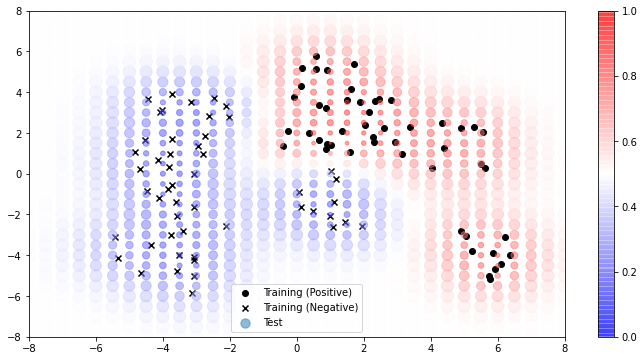

In [7]:
plot(x_fit, y_fit, x_predict, p_predict, sigma_f_predict)